# Ensemble methods with scikit-learn and XGBoost 🧑‍🤝‍🧑🧑‍🤝‍🧑

Let's train ensemble models on our toy-dataset.

## What will you learn in this course? 🧐🧐
This lecture is a follow-along demo that will guide you through the steps of building ensemble models, choosing the base estimators, optimizing the hyperparameters and evaluating the performances on actual data.

* Preprocessing
    * Training pipeline
    * Test pipeline
* Bagging
    * Bagging with logistic regression as base estimator
    * Bagging with decision tree as base estimator
* Boosting
    * AdaBoost
    * scikit-learn's GradientBoosting
    * XGBoost
* Voting
* Stacking

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
# import ensemble methods
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from xgboost import XGBClassifier
# import base estimators
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid deprecation warnings

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE

In [2]:
# Import dataset
print("Loading dataset...")
dataset = pd.read_csv("src/Data.csv")
print("...Done.")
print()

Loading dataset...
...Done.



In [3]:
# Basic stats
print("Number of rows : {}".format(dataset.shape[0]))
print()

print("Display of dataset: ")
display(dataset.head())
print()

print("Basics statistics: ")
data_desc = dataset.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")
display(100*dataset.isnull().sum()/dataset.shape[0])


Number of rows : 10

Display of dataset: 


,Country,Age,Salary,Purchased
0,France,44.0,72000,No
1,Spain,27.0,48000,Yes
2,Germany,30.0,54000,No
3,Spain,38.0,61000,No
4,Germany,40.0,69000,Yes



Basics statistics: 


,Country,Age,Salary,Purchased
count,10,9.000000,10.000000,10
unique,3,NaN,NaN,2
top,France,NaN,NaN,No
freq,4,NaN,NaN,5
mean,NaN,38.777778,64300.000000,NaN
std,NaN,7.693793,11681.419244,NaN
min,NaN,27.000000,48000.000000,NaN
25%,NaN,35.000000,55000.000000,NaN
50%,NaN,38.000000,64000.000000,NaN
75%,NaN,44.000000,71250.000000,NaN



Percentage of missing values: 


Country       0.0
Age          10.0
Salary        0.0
Purchased     0.0
dtype: float64

## Preprocessing

In [4]:
# Separate target variable Y from features X
print("Separating labels from features...")
target_variable = "Purchased"

X = dataset.drop(target_variable, axis = 1)
Y = dataset.loc[:,target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

Separating labels from features...
...Done.

Y : 
0     No
1    Yes
2     No
3     No
4    Yes
Name: Purchased, dtype: object

X :
   Country   Age  Salary
0   France  44.0   72000
1    Spain  27.0   48000
2  Germany  30.0   54000
3    Spain  38.0   61000
4  Germany  40.0   69000


In [5]:
# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []
for i,t in X.dtypes.iteritems():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
    else :
        categorical_features.append(i)

print('Found numeric features ', numeric_features)
print('Found categorical features ', categorical_features)

Found numeric features  ['Age', 'Salary']
Found categorical features  ['Country']


In [6]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
# WARNING : don't forget stratify=Y for classification problems
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify = Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [7]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # missing values will be replaced by columns' mean
    ('scaler', StandardScaler())
])

In [8]:
# Create pipeline for categorical features
categorical_transformer = OneHotEncoder(drop='first') # no missing values in categorical data, so we only need the OHE

In [9]:
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [10]:
# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5]) # MUST use this syntax because X_train is a numpy array and not a pandas DataFrame anymore
print()
# Label encoding
print("Encoding labels...")
print(Y_train.head())
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("...Done")
print(Y_train[0:5])

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head()) 
X_test = preprocessor.transform(X_test) # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print('...Done.')
print(X_test[0:5,:]) # MUST use this syntax because X_test is a numpy array and not a pandas DataFrame anymore
print()
# Label encoding
print("Encoding labels...")
print(Y_test[0:5])
Y_test = encoder.transform(Y_test)
print("...Done")
print(Y_test[0:5])

Performing preprocessings on train set...
   Country   Age  Salary
0   France  44.0   72000
4  Germany  40.0   69000
6    Spain   NaN   52000
9   France  37.0   67000
3    Spain  38.0   61000
...Done.
[[ 1.61706195e+00  1.46885753e+00  0.00000000e+00  0.00000000e+00]
 [ 8.22715727e-01  1.09777773e+00  1.00000000e+00  0.00000000e+00]
 [-1.41104234e-15 -1.00500778e+00  0.00000000e+00  1.00000000e+00]
 [ 2.26956063e-01  8.50391200e-01  0.00000000e+00  0.00000000e+00]
 [ 4.25542617e-01  1.08231607e-01  0.00000000e+00  1.00000000e+00]]

Encoding labels...
0     No
4    Yes
6     No
9    Yes
3     No
Name: Purchased, dtype: object
...Done
[0 1 0 1 0]
Performing preprocessings on test set...
   Country   Age  Salary
8  Germany  50.0   83000
7   France  48.0   79000
...Done.
[[2.80858127 2.82948345 1.         0.        ]
 [2.41140816 2.33471038 0.         0.        ]]

Encoding labels...
8     No
7    Yes
Name: Purchased, dtype: object
...Done
[0 1]


## Bagging
### Bagging with logistic regression as base estimator

In [11]:
# Perform grid search
print("Grid search...")
logistic_regression = LogisticRegression(max_iter = 1000) # max_iter changed because of convergence warning
model = BaggingClassifier(logistic_regression)

# Grid of values to be tested
params = {
    'base_estimator__C': [0.01, 0.05, 0.1, 0.5,], # base_estimator__ prefix because C is a parameter from LogisticRegression! 
    'n_estimators': [5, 10, 20, 30] # n_estimators is a hyperparameter of the ensemble method
}
print(params)
gridsearch = GridSearchCV(model, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)
print()
print("Accuracy on training set : ", gridsearch.score(X_train, Y_train))
print("Accuracy on test set : ", gridsearch.score(X_test, Y_test))

Grid search...
{'base_estimator__C': [0.01, 0.05, 0.1, 0.5], 'n_estimators': [5, 10, 20, 30]}
...Done.
Best hyperparameters :  {'base_estimator__C': 0.05, 'n_estimators': 5}
Best validation accuracy :  0.5

Accuracy on training set :  0.5
Accuracy on test set :  0.5


### Bagging with decision tree as base estimator

In [12]:
# Perform grid search
print("Grid search...")
decision_tree = DecisionTreeClassifier()
model = BaggingClassifier(decision_tree)

# Grid of values to be tested
params = {
    'base_estimator__max_depth': [1, 2, 3],
    'base_estimator__min_samples_leaf': [1, 2, 3],
    'base_estimator__min_samples_split': [2, 3, 4],
    'n_estimators': [2, 4, 6, 8, 10]
}
print(params)
gridsearch = GridSearchCV(model, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)
print()
print("Accuracy on training set : ", gridsearch.score(X_train, Y_train))
print("Accuracy on test set : ", gridsearch.score(X_test, Y_test))

Grid search...
{'base_estimator__max_depth': [1, 2, 3], 'base_estimator__min_samples_leaf': [1, 2, 3], 'base_estimator__min_samples_split': [2, 3, 4], 'n_estimators': [2, 4, 6, 8, 10]}
...Done.
Best hyperparameters :  {'base_estimator__max_depth': 3, 'base_estimator__min_samples_leaf': 2, 'base_estimator__min_samples_split': 3, 'n_estimators': 2}
Best validation accuracy :  0.611111111111111

Accuracy on training set :  0.5
Accuracy on test set :  0.5


## Boosting
### Adaboost
#### Adaboost with logistic regression as base estimator

In [13]:
# Perform grid search
print("Grid search...")
logistic_regression = LogisticRegression(max_iter = 1000) # max_iter changed because of convergence warning
model = AdaBoostClassifier(logistic_regression)

# Grid of values to be tested
params = {
    'base_estimator__C': [0.01, 0.05, 0.1, 0.5,], # base_estimator__ prefix because C is a parameter from LogisticRegression! 
    'n_estimators': [5, 10, 20, 30] # n_estimators is a hyperparameter of the ensemble method
}
print(params)
gridsearch = GridSearchCV(model, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)
print()
print("Accuracy on training set : ", gridsearch.score(X_train, Y_train))
print("Accuracy on test set : ", gridsearch.score(X_test, Y_test))

Grid search...
{'base_estimator__C': [0.01, 0.05, 0.1, 0.5], 'n_estimators': [5, 10, 20, 30]}
...Done.
Best hyperparameters :  {'base_estimator__C': 0.01, 'n_estimators': 5}
Best validation accuracy :  0.38888888888888884

Accuracy on training set :  0.625
Accuracy on test set :  0.5


#### Adaboost with decision tree as base estimator

In [14]:
# Perform grid search
print("Grid search...")
decision_tree = DecisionTreeClassifier()
model = AdaBoostClassifier(decision_tree)

# Grid of values to be tested
params = {
    'base_estimator__max_depth': [1, 2, 3],
    'base_estimator__min_samples_leaf': [1, 2, 3],
    'base_estimator__min_samples_split': [2, 3, 4],
    'n_estimators': [2, 4, 6, 8, 10]
}
print(params)
gridsearch = GridSearchCV(model, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)
print()
print("Accuracy on training set : ", gridsearch.score(X_train, Y_train))
print("Accuracy on test set : ", gridsearch.score(X_test, Y_test))

Grid search...
{'base_estimator__max_depth': [1, 2, 3], 'base_estimator__min_samples_leaf': [1, 2, 3], 'base_estimator__min_samples_split': [2, 3, 4], 'n_estimators': [2, 4, 6, 8, 10]}
...Done.
Best hyperparameters :  {'base_estimator__max_depth': 1, 'base_estimator__min_samples_leaf': 1, 'base_estimator__min_samples_split': 2, 'n_estimators': 2}
Best validation accuracy :  0.38888888888888884

Accuracy on training set :  0.75
Accuracy on test set :  0.5


### Scikit-learn's GradientBoosting
#### Boosting with logistic regression as base estimator: forbidden ⛔️

In [15]:
# Perform grid search
print("Grid search...")
logistic_regression = LogisticRegression(max_iter = 1000) # max_iter changed because of convergence warning
model = GradientBoostingClassifier(logistic_regression) # this will fail: only decision trees are accepted as base estimators in GradientBoosting !

Grid search...


TypeError: __init__() takes 1 positional argument but 2 were given

#### Boosting with decision tree as base estimator
Actually, only trees are implemented in boosting models.

In [16]:
# Perform grid search
print("Grid search...")
model = GradientBoostingClassifier()

# Grid of values to be tested
params = {
    'max_depth': [1, 2, 3], # no base_estimator_ prefix because these are all arguments of GradientBoostingClassifier
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4],
    'n_estimators': [2, 4, 6, 8, 10]
}
print(params)
gridsearch = GridSearchCV(model, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)
print()
print("Accuracy on training set : ", gridsearch.score(X_train, Y_train))
print("Accuracy on test set : ", gridsearch.score(X_test, Y_test))

Grid search...
{'max_depth': [1, 2, 3], 'min_samples_leaf': [1, 2, 3], 'min_samples_split': [2, 3, 4], 'n_estimators': [2, 4, 6, 8, 10]}
...Done.
Best hyperparameters :  {'max_depth': 1, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 2}
Best validation accuracy :  0.38888888888888884

Accuracy on training set :  0.75
Accuracy on test set :  0.5


## XGBoost
XGBoost is a different library, but it provides a [scikit-learn API](https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.sklearn) that allows to train a model as if it had been built from a scikit-learn class.

In [17]:
# Perform grid search
print("Grid search...")
xgboost = XGBClassifier()

# Grid of values to be tested
params = {
    'max_depth': [2, 4, 6], # exactly the same role as in scikit-learn
    'min_child_weight': [1, 2, 3], # effect is more or less similar to min_samples_leaf and min_samples_split
    'n_estimators': [2, 4, 6, 8,] # exactly the same role as in scikit-learn
}
print(params)
gridsearch = GridSearchCV(xgboost, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)
print()
print("Accuracy on training set : ", gridsearch.score(X_train, Y_train))
print("Accuracy on test set : ", gridsearch.score(X_test, Y_test))

Grid search...
{'max_depth': [2, 4, 6], 'min_child_weight': [1, 2, 3], 'n_estimators': [2, 4, 6, 8]}
...Done.
Best hyperparameters :  {'max_depth': 2, 'min_child_weight': 2, 'n_estimators': 2}
Best validation accuracy :  0.5

Accuracy on training set :  0.5
Accuracy on test set :  0.5


## Voting
Contrary to bagging and boosting, the voting classifier is meant to mix different base estimators. Let's see an example with three base estimators:
* logistic regression
* decision tree
* SVM with rbf kernel

In [18]:
# Logistic regression
# Perform grid search
print("Grid search...")
logreg = LogisticRegression()

# Grid of values to be tested
params = {
    'C': [0.1, 1.0, 10.0]
}
logreg_opt = GridSearchCV(logreg, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
logreg_opt.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", logreg_opt.best_params_)
print("Best validation accuracy : ", logreg_opt.best_score_)
print()
print("Accuracy on training set : ", logreg_opt.score(X_train, Y_train))
print("Accuracy on test set : ", logreg_opt.score(X_test, Y_test))

Grid search...
...Done.
Best hyperparameters :  {'C': 10.0}
Best validation accuracy :  0.611111111111111

Accuracy on training set :  0.75
Accuracy on test set :  0.5


In [19]:
# Decision tree
# Perform grid search
print("Grid search...")
dt = DecisionTreeClassifier()

# Grid of values to be tested
params = {
    'max_depth': [1, 2, 3], 
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [2, 3, 4]
}
dt_opt = GridSearchCV(dt, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
dt_opt.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", dt_opt.best_params_)
print("Best validation accuracy : ", dt_opt.best_score_)
print()
print("Accuracy on training set : ", dt_opt.score(X_train, Y_train))
print("Accuracy on test set : ", dt_opt.score(X_test, Y_test))

Grid search...
...Done.
Best hyperparameters :  {'max_depth': 1, 'min_samples_leaf': 2, 'min_samples_split': 3}
Best validation accuracy :  0.5

Accuracy on training set :  0.625
Accuracy on test set :  0.5


In [20]:
# SVM
# Perform grid search
print("Grid search...")
svm = SVC(kernel = 'rbf', probability = True)

# Grid of values to be tested
params = {
    'C': [0.1, 1.0, 10.0],
    'gamma': [0.1, 1.0, 10.0]
}
svm_opt = GridSearchCV(svm, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
svm_opt.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", svm_opt.best_params_)
print("Best validation accuracy : ", svm_opt.best_score_)
print()
print("Accuracy on training set : ", svm_opt.score(X_train, Y_train))
print("Accuracy on test set : ", svm_opt.score(X_test, Y_test))

Grid search...
...Done.
Best hyperparameters :  {'C': 0.1, 'gamma': 10.0}
Best validation accuracy :  0.5555555555555555

Accuracy on training set :  1.0
Accuracy on test set :  0.5


In [21]:
# Voting
voting = VotingClassifier(estimators=[("logistic", logreg), ("tree", dt), ("svm", svm)], voting='soft') # soft: use probabilities for voting
voting.fit(X_train, Y_train)
print("Accuracy on training set : ", voting.score(X_train, Y_train))
print("Accuracy on test set : ", voting.score(X_test, Y_test))

Accuracy on training set :  0.875
Accuracy on test set :  0.0


## Stacking
As voting, the stacking concerns different base estimators, but this time they will be used to estimate independent probabilities that will be plugged as input of a final estimator. The default final estimator is LogisticRegression, but it can be changed using the `final_estimator` parameter.

In the examples below, the models `logreg`, `tree` and `svm` have already been optimized through a grid search.

In [22]:
# Default: LogisticRegression will be used as final estimator
print('Training stacking classifier...')
stacking = StackingClassifier(estimators = [("logistic", logreg), ("tree", dt), ("svm", svm)], cv = 3)
preds = stacking.fit_transform(X_train, Y_train)
predictions = pd.DataFrame(preds, columns=stacking.named_estimators_.keys())
print('...Done.')
display(predictions)
print("Accuracy on training set : ", stacking.score(X_train, Y_train))
print("Accuracy on test set : ", stacking.score(X_test, Y_test))

Training stacking classifier...
...Done.


,logistic,tree,svm
0,0.441257,0.0,0.633595
1,0.490859,1.0,0.127465
2,0.379211,0.0,0.862778
3,0.572142,1.0,0.114630
4,0.406044,0.0,0.735506
5,0.564332,1.0,0.250769
6,0.605352,0.0,0.753250
7,0.540797,1.0,0.332807


Accuracy on training set :  0.0
Accuracy on test set :  0.5


:::tip Check for correlations
As the predictions used in stacking are supposed to be independent, it's a good practice to check the correlation matrix of the outputs from the different estimators. If some predictions have a strong correlation, it's better to re-train the stacking model by dropping one of the estimators
:::

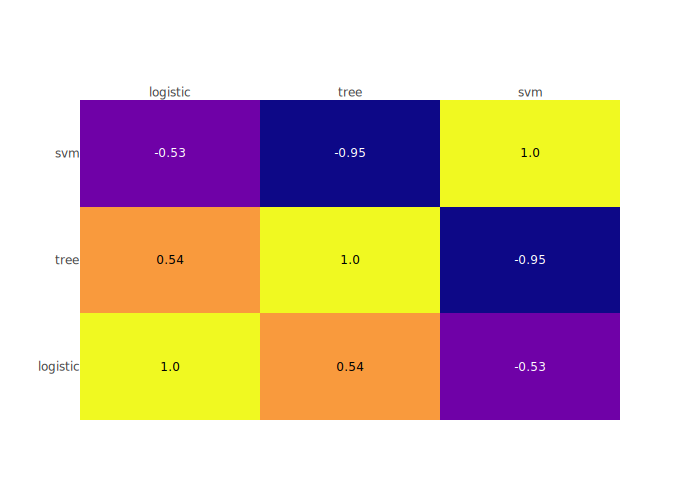

In [23]:
# Check the predictions are independent
# Correlation matrix
corr_matrix = predictions.corr().round(2)
import plotly.figure_factory as ff

fig = ff.create_annotated_heatmap(corr_matrix.values,
                                  x = corr_matrix.columns.tolist(),
                                  y = corr_matrix.index.tolist())


fig.show()

In [24]:
# Re-train by dropping the tree estimator because it's quite correlated with the logistic regression
print('Training stacking classifier...')
stacking = StackingClassifier(estimators = [("logistic", logreg), ("svm", svm)], cv = 3)
preds = stacking.fit_transform(X_train, Y_train)
predictions = pd.DataFrame(preds, columns=stacking.named_estimators_.keys())
print('...Done.')
display(predictions)
print("Accuracy on training set : ", stacking.score(X_train, Y_train))
print("Accuracy on test set : ", stacking.score(X_test, Y_test))

Training stacking classifier...
...Done.


,logistic,svm
0,0.441257,0.688604
1,0.490859,0.195893
2,0.379211,0.876702
3,0.572142,0.179399
4,0.406044,0.773772
5,0.564332,0.341632
6,0.605352,0.788086
7,0.540797,0.419795


Accuracy on training set :  0.0
Accuracy on test set :  0.5


In [25]:
# DecisionTree as final estimator
print('Training stacking classifier...')
stacking = StackingClassifier(estimators = [("logistic", logreg), ("svm", svm)], final_estimator = DecisionTreeClassifier(), cv = 3)
preds = stacking.fit_transform(X_train, Y_train)
predictions = pd.DataFrame(preds, columns=stacking.named_estimators_.keys())
print('...Done.')
display(predictions)
print("Accuracy on training set : ", stacking.score(X_train, Y_train))
print("Accuracy on test set : ", stacking.score(X_test, Y_test))

Training stacking classifier...
...Done.


,logistic,svm
0,0.441257,0.651634
1,0.490859,0.083022
2,0.379211,0.902867
3,0.572142,0.072386
4,0.406044,0.772935
5,0.564332,0.200781
6,0.605352,0.792466
7,0.540797,0.287195


Accuracy on training set :  0.25
Accuracy on test set :  1.0
